## Семинар 7: "Методы оптимизации"

ФИО: Долгая Любовь Васильевна

In [3]:
import numpy as np
from sklearn.datasets import fetch_openml

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

import seaborn as sns
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [29]:
import abc

class Optimizer(abc.ABC):
    def __init__(self, list_params):
        self.params = list(list_params)
  
    def step(self, err):
        pass

    def finish(self):
        with torch.no_grad():
            for param in self.params:
                param.grad.data.zero_()

class GD(Optimizer):
    def __init__(self, list_params, learning_rate):
        super().__init__(list_params)

        self.learning_rate = learning_rate

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            for param in self.params:
                param -= self.learning_rate * param.grad

        self.finish()

class Momentum(GD):
    def __init__(self, list_params, learning_rate, nu=0.1):
        super().__init__(list_params, learning_rate)

        self.nu = nu

        self.vs = [torch.zeros_like(param) for param in self.params]

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                v.copy_(self.nu * v + self.learning_rate * param.grad)                

                param -= v

        self.finish()

class NAG(GD):
    def __init__(self, list_params, learning_rate, nu=0.1):
        super().__init__(list_params, learning_rate)

        self.nu = nu

        self.vs = [torch.zeros_like(param) for param in self.params]

    def step(self, err):
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param -= self.nu * v

        loss = err()
        loss.backward()

        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param += self.nu * v

                v.copy_(self.nu * v + self.learning_rate * param.grad)        

                param -= v

        self.finish()

class RMSProp(GD):
    def __init__(self, list_params, learning_rate, gamma=0.9):
        super().__init__(list_params, learning_rate)

        self.gamma = gamma

        self.g_sq_list = [torch.zeros_like(param) for param in self.params]

        self.eps = 10**-8

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            for g_sq, param in zip(self.g_sq_list, self.params):
                g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad**2)

                param -= self.learning_rate * param.grad / (g_sq + self.eps)**0.5

        self.finish()

class Adadelta(Optimizer):
    def __init__(self, list_params,learning_rate, gamma=0.9):
        super().__init__(list_params)

        self.gamma = gamma


        self.pred_param = [torch.zeros_like(param) for param in self.params]
#         self.param = [torch.zeros_like(param) for param in list_params]
        self.t = [torch.zeros_like(param) for param in self.params]
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]

        self.eps = 10**-8

    def step(self, err):
        loss = err()
        loss.backward()

        with torch.no_grad():
            for g_sq, param, pred_param, t in zip(self.g_sq_list, self.params, self.pred_param, self.t):    
                g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad**2)
                d = (t + self.eps)**0.5 / (g_sq + self.eps)**0.5 * param.grad
                t.copy_(self.gamma * t + (1 - self.gamma) * (param - pred_param)**2)
                pred_param.copy_(param)
                param.copy_(param - d)

        self.finish()

class Adam(GD):
    def __init__(self, list_params, learning_rate, b1=0.9, b2=0.999):
        super().__init__(list_params, learning_rate)

        self.b1 = b1
        self.b2 = b2
        self.m = [torch.zeros_like(param) for param in self.params]
        self.v = [torch.zeros_like(param) for param in self.params]
        self.t = 0

        self.g_sq_list = [torch.zeros_like(param) for param in self.params]

        self.eps = 10**-8
    def step(self, err):
        loss = err()
        loss.backward()
        self.t += 1

        with torch.no_grad():
            for m,v,param in zip(self.m,self.v,self.params):
                m = self.b1 * m + (1 - self.b1) * param.grad
                v = self.b2 * v + (1 - self.b2) * param.grad ** 2
                _m = m / (1 - self.b1 ** self.t)
                _v = v / (1 - self.b2 ** self.t)
                
                param -= self.learning_rate / (np.sqrt(_v) + self.eps) * _m

        self.finish()
class Adagrad(GD):
    def __init__(self, list_params, learning_rate):
        super().__init__(list_params, learning_rate)
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            for g_sq, param in zip(self.g_sq_list, self.params):
                g_sq += param.grad ** 2
                param -= self.learning_rate * param.grad / (g_sq + self.eps) ** 0.5
        self.finish()


In [3]:
type(np.array([0]))

numpy.ndarray

In [5]:
def J(x, y):
    return x**2 + y**2

def J(x, y):
    if isinstance(x, np.ndarray):
        return x**2 * np.sin(x) + y**2 * np.sin(y)
    else:
        return x**2 * x.sin() + y**2 * y.sin()

"""
def J(x, y):
  return x**2 - y**2
"""

def J(x, y):
    if isinstance(x, np.ndarray):
        return x**2 * np.sin(x**2) + y**2 * np.sin(y**2)
    else:
        return x**2 * ((x**2).sin()) + y**2 * ((y**2).sin())

In [6]:
def make_var(x):
    x = np.array([float(x)])
    x = torch.from_numpy(x)
    return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

def err(J=J, x=x, y=y):
    return J(x, y)

learning_rate = 0.001

optimizers = [
#   GD([x, y], learning_rate),
#   Momentum([x, y], learning_rate),
#   NAG([x, y], learning_rate),
  #RMSProp([x, y], learning_rate),
#   Adadelta([x, y]),
  Adam([x,y], learning_rate)
]

all_points = []

for optim in optimizers:
    with torch.no_grad():
        x.copy_(torch.tensor(-6.0))
        y.copy_(torch.tensor(2))

    points = []

    for i in range(200):
        points.append((x.item(), y.item()))
        optim.step(err)
        #points.append((x.item(), y.item()))

    print(err())

    points = np.array(points)
    all_points.append(points)

tensor([-39.1761], dtype=torch.float64, grad_fn=<AddBackward0>)


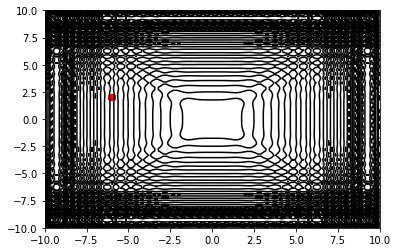

In [7]:
for points, color in zip(all_points, ["r", "g", "b", "yellow", "purple"]):
  plt.scatter(points[:, 0], points[:, 1], c=color)
  plt.plot(points[:, 0], points[:, 1], c=color)

size = 10

X = np.linspace(-size, size, 100)
Y = np.linspace(-size, size, 100)

X, Y = np.meshgrid(X, Y)
Z = J(X, Y)

plt.contour(X, Y, Z, colors='k')

axes = plt.gca()
axes.set_xlim([-size, size])
axes.set_ylim([-size, size])

plt.show()

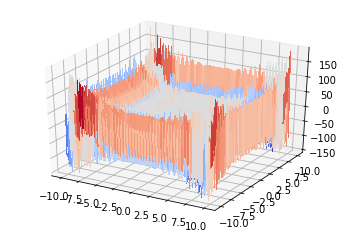

In [8]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [9]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

def J(x,y):
    return x**2 + y**2

In [10]:
def make_var(x):
  x = np.array([float(x)])
  x = torch.from_numpy(x)
  return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

def err(J=J, x=x, y=y):
  return J(x, y)

learning_rate = 1

optimizers = [
  GD([x, y], learning_rate),
  Momentum([x, y], learning_rate),
  NAG([x, y], learning_rate),
#   RMSProp([x, y], learning_rate),
  Adadelta([x, y]),
  Adam([x,y], learning_rate)
]
opt = [
  "GD",
  "Momentum",
  "NAG",
#   RMSProp([x, y], learning_rate),
  "Adadelta",
  "Adam"
]

all_points = []

for j in range(len(optimizers)):
  with torch.no_grad():
    x.copy_(torch.tensor(-6.0))
    y.copy_(torch.tensor(2))

  points = []

  for i in range(200):
    points.append((x.item(), y.item()))
    optimizers[j].step(err)
    #points.append((x.item(), y.item()))

  print(err(),opt[j])

  points = np.array(points)
  all_points.append(points)

tensor([40.], dtype=torch.float64, grad_fn=<AddBackward0>) GD
tensor([3.1623e-44], dtype=torch.float64, grad_fn=<AddBackward0>) Momentum
tensor([7.4000e+30], dtype=torch.float64, grad_fn=<AddBackward0>) NAG
tensor([3.1067e-75], dtype=torch.float64, grad_fn=<AddBackward0>) Adadelta
tensor([0.0070], dtype=torch.float64, grad_fn=<AddBackward0>) Adam


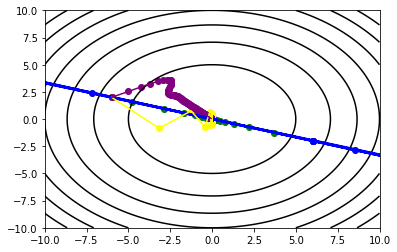

In [11]:
for points, color in zip(all_points, ["r", "g", "b", "yellow", "purple"]):
  plt.scatter(points[:, 0], points[:, 1], c=color)
  plt.plot(points[:, 0], points[:, 1], c=color)

size = 10

X = np.linspace(-size, size, 100)
Y = np.linspace(-size, size, 100)

X, Y = np.meshgrid(X, Y)
Z = J(X, Y)

plt.contour(X, Y, Z, colors='k')

axes = plt.gca()
axes.set_xlim([-size, size])
axes.set_ylim([-size, size])

plt.show()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [12]:
def J(x, y):
  if isinstance(x, np.ndarray):
    return x**2 * np.sin(x) + y**2 * np.sin(y)
  else:
    return x**2 * ((x**2).sin()) + y**2 * ((y**2).sin())
def make_var(x):
  x = np.array([float(x)])
  x = torch.from_numpy(x)
  return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

def err(J=J, x=x, y=y):
  return J(x, y)

learning_rate = 1

optimizers = [
  GD([x, y], learning_rate),
  Momentum([x, y], learning_rate),
  NAG([x, y], learning_rate),
#   RMSProp([x, y], learning_rate),
  Adadelta([x, y]),
  Adam([x,y], learning_rate)
]
opt = [
  "GD",
  "Momentum",
  "NAG",
#   RMSProp([x, y], learning_rate),
  "Adadelta",
  "Adam"
]

all_points = []

for j in range(len(optimizers)):
  with torch.no_grad():
    x.copy_(torch.tensor(-6.0))
    y.copy_(torch.tensor(2))

  points = []

  for i in range(200):
    points.append((x.item(), y.item()))
    optimizers[j].step(err)
    #points.append((x.item(), y.item()))

  print(err(),opt[j])

  points = np.array(points)
  all_points.append(points)

tensor([nan], dtype=torch.float64, grad_fn=<AddBackward0>) GD
tensor([nan], dtype=torch.float64, grad_fn=<AddBackward0>) Momentum
tensor([nan], dtype=torch.float64, grad_fn=<AddBackward0>) NAG
tensor([-5.2519], dtype=torch.float64, grad_fn=<AddBackward0>) Adadelta
tensor([-43.4852], dtype=torch.float64, grad_fn=<AddBackward0>) Adam


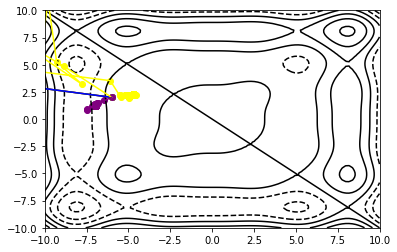

In [13]:
for points, color in zip(all_points, ["r", "g", "b", "yellow", "purple"]):
  plt.scatter(points[:, 0], points[:, 1], c=color)
  plt.plot(points[:, 0], points[:, 1], c=color)

size = 10

X = np.linspace(-size, size, 100)
Y = np.linspace(-size, size, 100)

X, Y = np.meshgrid(X, Y)
Z = J(X, Y)

plt.contour(X, Y, Z, colors='k')

axes = plt.gca()
axes.set_xlim([-size, size])
axes.set_ylim([-size, size])

plt.show()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [14]:
def J(x, y):
  if isinstance(x, np.ndarray):
    return x**2 * np.sin(x**2) + y**2 * np.sin(y**2)
  else:
    return x**2 * ((x**2).sin()) + y**2 * ((y**2).sin())
def make_var(x):
  x = np.array([float(x)])
  x = torch.from_numpy(x)
  return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

def err(J=J, x=x, y=y):
  return J(x, y)

learning_rate = 1

optimizers = [
#   GD([x, y], learning_rate),
#   Momentum([x, y], learning_rate),
#   NAG([x, y], learning_rate),
#   RMSProp([x, y], learning_rate),
  Adadelta([x, y]),
  Adam([x,y], learning_rate)
]
opt = [
#   "GD",
#   "Momentum",
#   "NAG",
#   RMSProp([x, y], learning_rate),
  "Adadelta",
  "Adam"
]

all_points = []

for j in range(len(optimizers)):
  with torch.no_grad():
    x.copy_(torch.tensor(-6.0))
    y.copy_(torch.tensor(2))

  points = []

  for i in range(200):
    points.append((x.item(), y.item()))
    optimizers[j].step(err)
    #points.append((x.item(), y.item()))

  print(err(),opt[j])

  points = np.array(points)
  all_points.append(points)

tensor([-5.2519], dtype=torch.float64, grad_fn=<AddBackward0>) Adadelta
tensor([-43.4852], dtype=torch.float64, grad_fn=<AddBackward0>) Adam


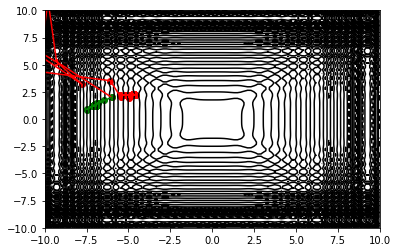

In [15]:
for points, color in zip(all_points, ["r", "g", "b", "yellow", "purple"]):
  plt.scatter(points[:, 0], points[:, 1], c=color)
  plt.plot(points[:, 0], points[:, 1], c=color)

size = 10

X = np.linspace(-size, size, 100)
Y = np.linspace(-size, size, 100)

X, Y = np.meshgrid(X, Y)
Z = J(X, Y)

plt.contour(X, Y, Z, colors='k')

axes = plt.gca()
axes.set_xlim([-size, size])
axes.set_ylim([-size, size])

plt.show()

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [5]:

transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
from IPython.display import clear_output
def train(network, epochs, learning_rate, optim, ravel_init=True):
    loss = nn.NLLLoss()
    optimizer = optim(network.parameters(), learning_rate=learning_rate)

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
#                 loss_batch.backward()
                optimizer.step(lambda: loss(prediction,y))
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 9... (Train/Test) NLL: 0.312/0.680	Accuracy: 0.981/0.970


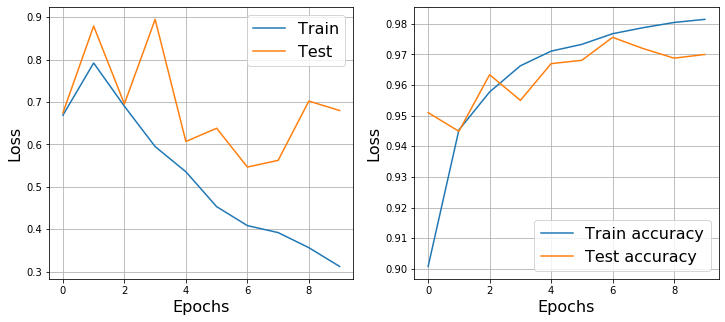

In [20]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=Adam)

Epoch 9... (Train/Test) NLL: 0.240/0.232	Accuracy: 0.931/0.933


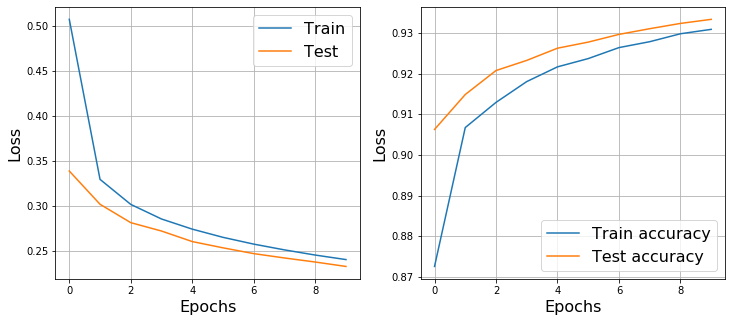

In [26]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=Adagrad)

Epoch 9... (Train/Test) NLL: 0.173/0.241	Accuracy: 0.967/0.957


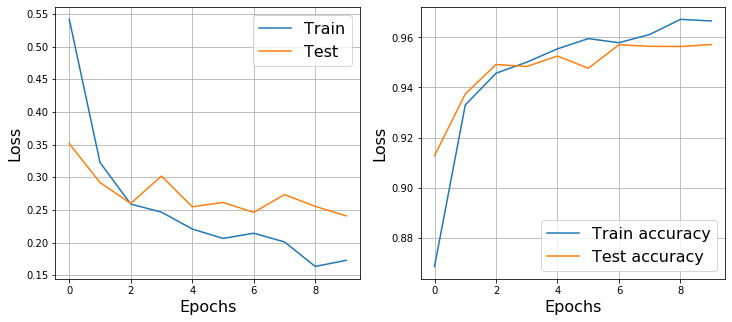

In [22]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001, optim=Adadelta)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [13]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU(),)
        self.linear_layers = nn.Sequential(nn.Linear(image_size // 2 * image_size // 2 * 16, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.382/0.344	Accuracy: 0.982/0.983


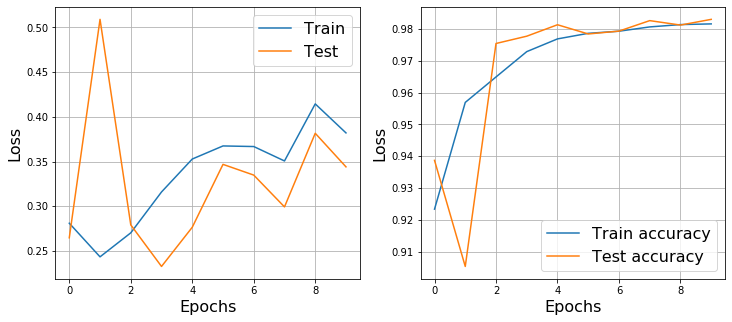

In [32]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=Adam)

Epoch 9... (Train/Test) NLL: 0.182/0.172	Accuracy: 0.948/0.950


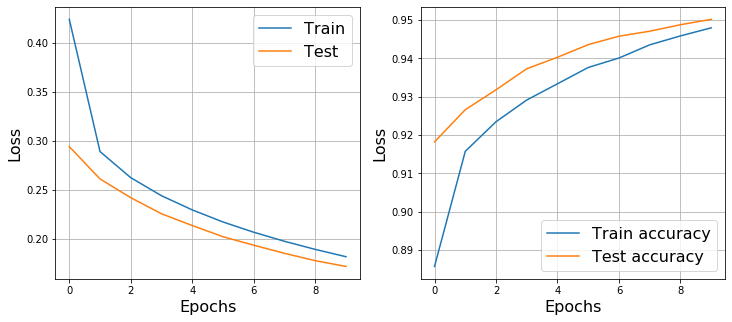

In [33]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=Adagrad)

Epoch 9... (Train/Test) NLL: 0.060/0.051	Accuracy: 0.982/0.984


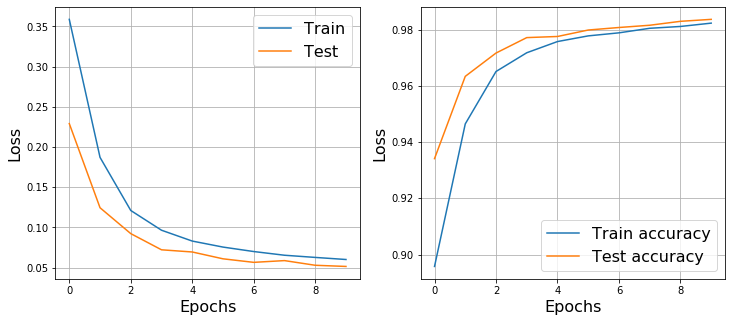

In [30]:
network = ConvClassifier(image_size=28)
train(network, 10, 0.001, ravel_init=False, optim=Adadelta)

Adam показал лучшие результаты в обоих случаях.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: